# Get the names and indexes of the response genes.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import os
import torch

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.models.monet_ae import MonetDense
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

In [8]:
response_genes=np.array(['Ace2', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar', 'Arhgap36',
       'Baiap2', 'Ccnd2', 'Cd24a', 'Cdkn1a', 'Cenpe', 'Chat', 'Coch',
       'Col25a1', 'Cplx3', 'Cpne5', 'Creb3l1', 'Cspg5', 'Cyp19a1',
       'Cyp26a1', 'Dgkk', 'Ebf3', 'Egr2', 'Ermn', 'Esr1', 'Etv1',
       'Fbxw13', 'Fezf1', 'Gbx2', 'Gda', 'Gem', 'Gjc3', 'Greb1',
       'Irs4', 'Isl1', 'Klf4', 'Krt90', 'Lmod1', 'Man1a', 'Mbp', 'Mki67',
       'Mlc1', 'Myh11', 'Ndnf', 'Ndrg1', 'Necab1', 'Nnat', 'Nos1',
       'Npas1', 'Nup62cl', 'Omp', 'Onecut2', 'Opalin', 'Pak3', 'Pcdh11x',
       'Pgr', 'Plin3', 'Pou3f2', 'Rgs2', 'Rgs5', 'Rnd3', 'Scgn',
       'Serpinb1b', 'Sgk1', 'Slc15a3', 'Slc17a6', 'Slc17a8', 'Slco1a4',
       'Sln', 'Sox4', 'Sox6', 'Sox8', 'Sp9', 'Synpr', 'Syt2', 'Syt4',
       'Sytl4', 'Th', 'Tiparp', 'Tmem108', 'Traf4', 'Ttn', 'Ttyh2'])

In [9]:
data = pd.read_csv("../data/raw/merfish.csv")

In [10]:
data = data.drop(["Fos", "Blank_1", "Blank_2", "Blank_3", "Blank_4", "Blank_5"], axis=1)

In [11]:
data = data.iloc[:, 9:]

In [12]:
data.shape, data.columns # should start with "Ace2"

((1027848, 155),
 Index(['Ace2', 'Adora2a', 'Aldh1l1', 'Amigo2', 'Ano3', 'Aqp4', 'Ar',
        'Arhgap36', 'Avpr1a', 'Avpr2',
        ...
        'Penk', 'Scg2', 'Sln', 'Sst', 'Tac1', 'Tac2', 'Th', 'Trh', 'Ucn3',
        'Vgf'],
       dtype='object', length=155))

In [13]:
response_indexes = [0,2,3,4,5,6,7,10,19,20,21,22,23,24,25,26,27,28,32,34,35,37,38,39,40,41,42,43,44,52,53,54,55,58,63,64,66,67,69,71,73,74,75,76,77,78,79,80,85,86,87,88,93,94,96,97,99,102,103,104,106,110,112,113,114,116,118,119,120,121,122,123,124,125,126,129,130,131,133,134,141,142,147,151]

In [4]:
IGNORANT_RADIUS = 0
AWARE_RADIUS = [5,10,15,20,25,30]

# Load the test losses for spatially ignorant baseline.

In [5]:
test_loss_rad_dict = {}

for rad in [IGNORANT_RADIUS]:
    with initialize(config_path="../config"):
        # try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
            test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        # except:
        #     try:
        #         OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
        #         print(cfg_from_terminal.training.filepath)
        #         output = test(cfg_from_terminal)
        #         trainer, l1_losses, inputs_BASE, gene_expressions_BASE, celltypes, test_results_BASE = output
        #         test_loss_rad_dict[rad] = test_results_BASE[0]['test_loss']
        #     except:
        #         print(f"Model with radius of {rad} micrometers doesn't exist :(")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.29it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__table2_FULL_no_celltypes__Adam.ckpt`
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[2])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[2])` instea

Testing: 0it [00:00, ?it/s]

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5700. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6019. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5667. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_c

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.34988829493522644    │
│       test_loss_mse       │    0.34988829493522644    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Load the test losses for spatially aware model.

In [27]:
loss_dict = {}
inputs_BASE_responses = inputs_BASE[:, response_indexes]

for rad in AWARE_RADIUS:
    with initialize(config_path="../config"):
        try:
            cfg_from_terminal = compose(config_name="config")
            OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 71)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.output_dimension", 84)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            OmegaConf.update(cfg_from_terminal, "training.logger_name", "table2_FULL_no_celltypes")
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "gpus", [2])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
            test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
        except:
            try:
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
                print(cfg_from_terminal.training.filepath)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs_SPATIAL, gene_expressions_SPATIAL, celltypes, test_results_SPATIAL = output
                test_loss_rad_dict[rad] = test_results_SPATIAL[0]['test_loss']
            except:
                print(f"Model with radius of {rad} micrometers doesn't exist :(")
    loss_dict[rad] = {}
    for i, gene in enumerate(response_genes):
        inputs_SPATIAL_responses = inputs_SPATIAL[:, response_indexes]
        current_gene = data.columns[response_indexes[i]]
        loss_dict[rad][current_gene] = {"base": torch.mean( (inputs_BASE_responses[:, i] - gene_expressions_BASE[:, i]) ** 2 ).item(), "spatial": torch.mean( (inputs_SPATIAL_responses[:, i] - gene_expressions_SPATIAL[:, i]) ** 2 ).item()}
        loss_dict[rad][current_gene]["diff"] = loss_dict[rad][current_gene]["spatial"] - loss_dict[rad][current_gene]["base"]
        loss_dict[rad][current_gene]["percent_diff"] = (loss_dict[rad][current_gene]["diff"]/loss_dict[rad][current_gene]["base"]) * 100.0

MonetDense__[512, 512, 512, 512, 512, 512]__5__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.33it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__5__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3494284152984619     │
│       test_loss_mse       │    0.3494284152984619     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

MonetDense__[512, 512, 512, 512, 512, 512]__10__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__10__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3461569845676422     │
│       test_loss_mse       │    0.3461569845676422     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

MonetDense__[512, 512, 512, 512, 512, 512]__15__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.25it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__15__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33938685059547424    │
│       test_loss_mse       │    0.33938685059547424    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

MonetDense__[512, 512, 512, 512, 512, 512]__20__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__20__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3366208076477051     │
│       test_loss_mse       │    0.3366208076477051     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:19<00:00,  1.26it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.33311593532562256    │
│       test_loss_mse       │    0.33311593532562256    │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

MonetDense__[512, 512, 512, 512, 512, 512]__30__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]


MonetDense__[256, 256, 256, 256, 256, 256]__30__table2_FULL_no_celltypes__Adam


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../output/lightning_logs/checkpoints/MonetDense/MonetDense__[256, 256, 256, 256, 256, 256]__30__table2_FULL_no_celltypes__Adam.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3348855972290039     │
│       test_loss_mse       │    0.3348855972290039     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Get the losses for each response gene in both cases.

In [28]:
loss_dict

{5: {'Ace2': {'base': 0.14470702409744263,
   'spatial': 0.14529971778392792,
   'diff': 0.0005926936864852905,
   'percent_diff': 0.4095818362529404},
  'Aldh1l1': {'base': 0.6029497981071472,
   'spatial': 0.6033490896224976,
   'diff': 0.0003992915153503418,
   'percent_diff': 0.06622301170078271},
  'Amigo2': {'base': 0.41306960582733154,
   'spatial': 0.41165590286254883,
   'diff': -0.0014137029647827148,
   'percent_diff': -0.34224327930185716},
  'Ano3': {'base': 0.19442394375801086,
   'spatial': 0.1938006579875946,
   'diff': -0.0006232857704162598,
   'percent_diff': -0.32058076714667944},
  'Aqp4': {'base': 0.7678506374359131,
   'spatial': 0.7667004466056824,
   'diff': -0.0011501908302307129,
   'percent_diff': -0.1497935632470854},
  'Ar': {'base': 0.5081300139427185,
   'spatial': 0.5012067556381226,
   'diff': -0.006923258304595947,
   'percent_diff': -1.3624974149581344},
  'Arhgap36': {'base': 0.541377067565918,
   'spatial': 0.5351763367652893,
   'diff': -0.0062007

In [29]:
with open("0v60.json", "w") as file:
    json.dump(loss_dict, file)

# Plot the results.

In [10]:
import matplotlib.pyplot as plt

In [11]:
percent_differences = [-loss_dict[x]["percent_diff"] for x in loss_dict]

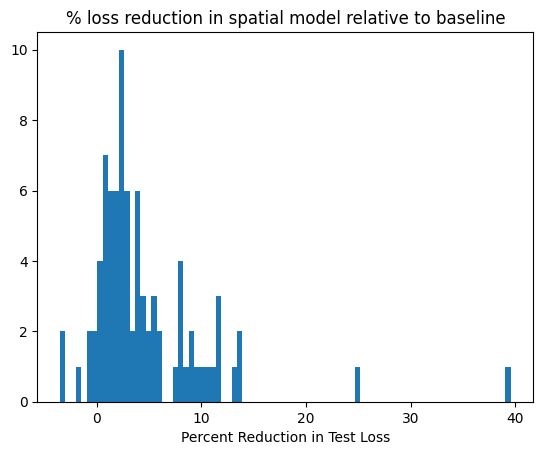

In [12]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% loss reduction in spatial model relative to baseline")
plt.xlabel("Percent Reduction in Test Loss")
plt.show()

# Identify the genes.

In [13]:
loss_dict_sorted = dict(sorted(loss_dict.items(), key=lambda item: item[1]["percent_diff"]))

In [14]:
loss_dict_sorted

{'Nnat': {'base': 0.01,
  'spatial': 0.0061,
  'diff': -0.004,
  'percent_diff': -39.5866},
 'Mbp': {'base': 0.0544,
  'spatial': 0.0409,
  'diff': -0.0135,
  'percent_diff': -24.8099},
 'Ebf3': {'base': 0.1611,
  'spatial': 0.139,
  'diff': -0.0221,
  'percent_diff': -13.7119},
 'Sln': {'base': 0.0535,
  'spatial': 0.0463,
  'diff': -0.0072,
  'percent_diff': -13.48},
 'Ermn': {'base': 0.7739,
  'spatial': 0.6704,
  'diff': -0.1035,
  'percent_diff': -13.3741},
 'Cd24a': {'base': 0.4986,
  'spatial': 0.4402,
  'diff': -0.0584,
  'percent_diff': -11.7219},
 'Greb1': {'base': 0.2096,
  'spatial': 0.1852,
  'diff': -0.0244,
  'percent_diff': -11.6531},
 'Myh11': {'base': 0.2398,
  'spatial': 0.2121,
  'diff': -0.0277,
  'percent_diff': -11.5574},
 'Sgk1': {'base': 0.9204,
  'spatial': 0.8201,
  'diff': -0.1002,
  'percent_diff': -10.8921},
 'Gda': {'base': 0.5421,
  'spatial': 0.4851,
  'diff': -0.057,
  'percent_diff': -10.5127},
 'Ndrg1': {'base': 0.9299,
  'spatial': 0.8371,
  'diff':

# Annotated Plot

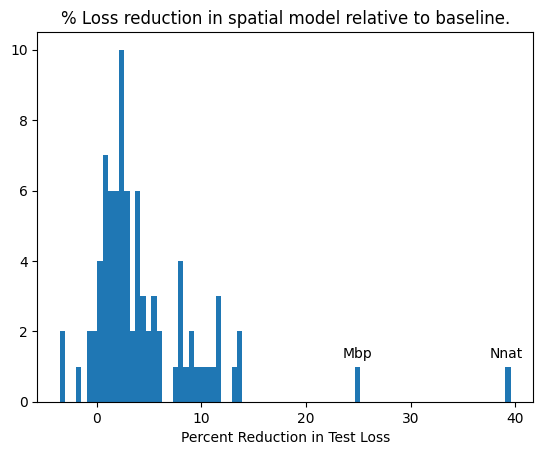

In [15]:
plt.hist(percent_differences, bins=len(loss_dict))
plt.title("% Loss reduction in spatial model relative to baseline.")
plt.xlabel("Percent Reduction in Test Loss")
plt.annotate("Nnat", xy=(39.5866-2, 1.25))
plt.annotate("Mbp", xy=(24.8099-1.3, 1.25))
plt.savefig("0VSspatial.png", dpi=300)
plt.show()

# Heatmap

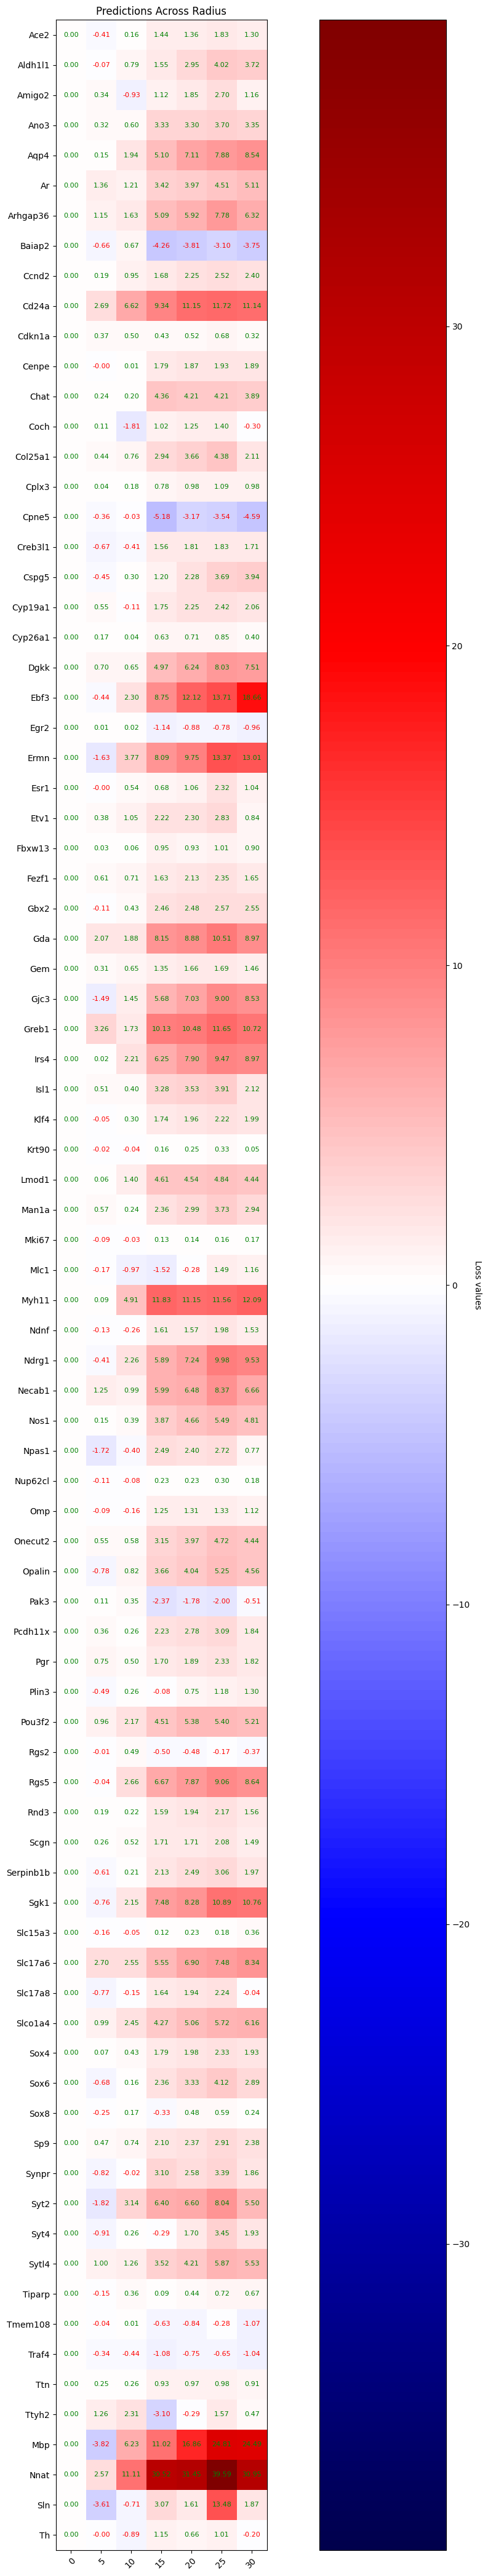

In [42]:
import numpy as np
import matplotlib.pyplot as plt

radius_values = list(range(0,31,5))
genes = [data.columns[i] for i in response_indexes]

loss_array = np.array([
    [-loss_dict[rad][gene]["percent_diff"] if rad != 0 else 0 for rad in radius_values] for gene in genes
])

# Set the figure size based on the dimensions of your data
cell_width = 2.5
cell_height = 0.5
fig, ax = plt.subplots(figsize=(cell_width*len(radius_values), cell_height*len(genes)))

im = ax.imshow(loss_array, cmap='seismic', vmin=-np.max(np.abs(loss_array)), vmax=np.max(np.abs(loss_array)))

# Add a colorbar for reference
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Loss values", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(radius_values)))
ax.set_xticklabels(radius_values)
ax.set_yticks(np.arange(len(genes)))
ax.set_yticklabels(genes)

# Adjust font size
ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Dynamically adjust text color based on cell value and format the number to 2 decimal places
for i in range(len(genes)):
    for j in range(len(radius_values)):
        if loss_array[i, j] < 0:  # If value is negative, use white text
            text_color = 'red'
        else:  # Otherwise, use black text
            text_color = 'green'
        text = ax.text(j, i, f"{loss_array[i, j]:.2f}",
                       ha="center", va="center", color=text_color, fontsize=8)

ax.set_title("Predictions Across Radius")
fig.tight_layout()
plt.show()